In [2]:
def featurize(df):
    del df["customerID"]
    df["gender"] = df["gender"].map({"Male": 1, "Female": 0})
    df["Partner"] = df["Partner"].map({"Yes": 1, "No": 0})
    df["Dependents"] = df["Dependents"].map({"Yes": 1, "No": 0})
    df["PhoneService"] = df["PhoneService"].map({"Yes": 1, "No": 0})
    df["MultipleLines"] = df["MultipleLines"].map({"No phone service": 0, "No": 1, "Yes": 2})
    df["InternetService"] = df["InternetService"].map({"No": 0, "DSL": 1, "Fiber optic": 2})
    df["OnlineSecurity"] = df["OnlineSecurity"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["OnlineBackup"] = df["OnlineBackup"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["DeviceProtection"] = df["DeviceProtection"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["TechSupport"] = df["TechSupport"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["StreamingTV"] = df["StreamingTV"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["StreamingMovies"] = df["StreamingMovies"].map({"Yes": 1, "No": 0, "No internet service": 2})
    df["Contract"] = df["Contract"].map({"One year": 1, "Two year": 0, "Month-to-month": 2})
    df["PaperlessBilling"] = df["PaperlessBilling"].map({"Yes": 1, "No": 0})
    df["PaymentMethod"] = df["PaymentMethod"].map({"Bank transfer (automatic)": 1, "Electronic check": 0, "Mailed check": 2, "Credit card (automatic)": 3})
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges'])
    df.reset_index(drop=True, inplace=True)
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
    return df

In [3]:
import pandas as pd

raw = pd.read_csv("rawdataset.csv")

train_df = raw.sample(frac=0.5, random_state=42)
test_df = raw.drop(train_df.index)

train_df = featurize(train_df)
test_df = featurize(test_df)
raw = featurize(raw)

train_df.to_csv("train.csv")
test_df.to_csv("test.csv")

/var/folders/y_/_zkv14m90_5gz3gr6tm4mn8r0000gn/T/ipykernel_17690/3718597344.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
/var/folders/y_/_zkv14m90_5gz3gr6tm4mn8r0000gn/T/ipykernel_17690/3718597344.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
/var/folders/y_/_zkv14m90_5gz3gr6tm4mn8r0000gn/T/ipykernel_17690/3718597344.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

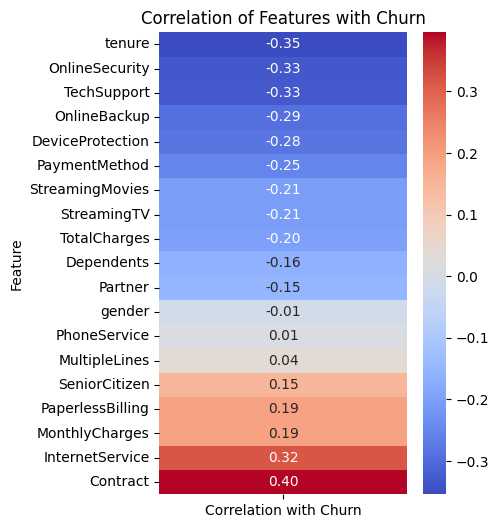

In [4]:
# Calculate the correlation matrix
correlation_matrix = raw.corr()

# Isolate the 'Churn' correlations and sort them
churn_correlations = correlation_matrix['Churn'].sort_values()

# For better readability, we can convert the correlations to a DataFrame
churn_correlations_df = pd.DataFrame(churn_correlations).reset_index()
churn_correlations_df.columns = ['Feature', 'Correlation with Churn']

# Exclude the 'Churn' row since it will always have a correlation of 1 with itself
churn_correlations_df = churn_correlations_df[churn_correlations_df['Feature'] != 'Churn']

# Visualize the simplified correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 6))
sns.heatmap(churn_correlations_df.set_index('Feature'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features with Churn')
plt.show()

In [5]:
# Assuming 'data' is your pandas DataFrame containing the dataset
X_train = raw.drop(['Churn'], axis=1)  # Drop non-predictor columns
y_train = raw['Churn']  
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_scaled, y_train)

selected_features = rfe.support_
ranking = rfe.ranking_
least_important_feature_indices = np.argsort(rfe.ranking_)[::-1]
least_important_features = X_train.columns[least_important_feature_indices]
print("Least important features by RFE:", least_important_features[:5])  # Adjust the slice as needed


Least important features by RFE: Index(['Partner', 'gender', 'DeviceProtection', 'Dependents', 'OnlineBackup'], dtype='object')


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

train_df = pd.read_csv("train.csv")

train_features = train_df[["gender","SeniorCitizen","Partner",
                          "Dependents","tenure","PhoneService",
                           "MultipleLines","InternetService","OnlineSecurity",
                           "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
                           "StreamingMovies", "Contract", "PaperlessBilling","PaymentMethod",
                           "MonthlyCharges", "TotalCharges"]]

train_labels = train_df["Churn"]

# Now let's define our models
lr_classifier = LogisticRegression(solver='lbfgs', max_iter=10000, C=0.01)

mlp_classifier = MLPClassifier(solver='lbfgs', alpha=15,
                               hidden_layer_sizes=(8, 2), random_state=11,max_iter=10000)

# train our models
lr_classifier.fit(train_features.to_numpy(),train_labels.to_numpy())
mlp_classifier.fit(train_features.to_numpy(),train_labels.to_numpy())

print ("Models trained successfully...")

#load test data
test_df = pd.read_csv("test.csv")

# Extract the input features
test_inputs = test_df[["gender","SeniorCitizen","Partner",
                          "Dependents","tenure","PhoneService",
                           "MultipleLines","InternetService","OnlineSecurity",
                           "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
                           "StreamingMovies", "Contract", "PaperlessBilling","PaymentMethod",
                           "MonthlyCharges", "TotalCharges"]]

y_actual = test_df["Churn"]

# predict using logistic regression model
y_predicted_lr = lr_classifier.predict(test_inputs.to_numpy())
lr_accuracy_score = accuracy_score(y_predicted_lr,y_actual)

# predict using mlp model
y_predicted_mlp = mlp_classifier.predict(test_inputs.to_numpy())
mlp_accuracy_score = accuracy_score(y_predicted_mlp,y_actual)

print (f"Accuracy of the Logistic Classifier on test data= {lr_accuracy_score}")
print (f"Accuracy of the MLP Classifier on test data = {mlp_accuracy_score}")

Models trained successfully...
Accuracy of the Logistic Classifier on test data= 0.7910617705664674
Accuracy of the MLP Classifier on test data = 0.793623683461429
